### PV Curve Analysis for 4-Bus Transmission System

This code performs a comprehensive P-V (Power-Voltage) curve analysis on a simplified 4-bus transmission system to investigate voltage stability margins under different load modeling approaches. The analysis systematically increases system loading until voltage collapse occurs, providing critical insights into system stability limits.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
from src.pv_curve import PVCurveAnalysis

def setup_system():
    """Setup the 4-bus system from the example"""
    # Define system
    barras = [1, 2, 3, 4]
    barras_tipo = {1: 0, 2: 2, 3: 2, 4: 2}  # 0: slack, 1: PV, 2: PQ
    
    # Complex powers (S = P + jQ) in pu
    potencias = {
        1: 0.0 - 0.7j,  # Slack bus
        2: -1.28 - 1.28j,  # Negative for load
        3: -0.32 - 0.16j,  # Negative for load
        4: -1.6 - 0.80j    # Negative for load
    }
    
    # Initial voltages
    v_inicial = {
        1: 1.0 + 0.0j,  # Reference voltage at slack bus
        2: 1.0 + 0.0j,
        3: 1.0 + 0.0j,
        4: 1.0 + 0.0j
    }
    
    # Lines (connections between buses)
    linhas = [(1, 2), (2, 3), (2, 4)]
    
    # Line impedances
    z12 = 0.0236 + 0.0233j
    z23 = 0.045 + 0.030j
    z24 = 0.0051 + 0.0005j
    
    # Series admittances of lines
    y12 = 1 / z12
    y23 = 1 / z23
    y24 = 1 / z24
    
    # Total shunt admittance per line (j0.01 pu)
    y_shunt = 0.01j
    
    # Build admittance matrix Y_bus
    Y_bus = np.zeros((4, 4), dtype=complex)
    
    # Diagonal elements (sum of admittances connected to bus)
    Y_bus[0, 0] = y12 + y_shunt/2  # Bus 1
    Y_bus[1, 1] = y12 + y23 + y24 + y_shunt/2 + y_shunt/2 + y_shunt/2  # Bus 2
    Y_bus[2, 2] = y23 + y_shunt/2  # Bus 3
    Y_bus[3, 3] = y24 + y_shunt/2  # Bus 4
    
    # Off-diagonal elements (negative of admittance between buses)
    Y_bus[0, 1] = Y_bus[1, 0] = -y12
    Y_bus[1, 2] = Y_bus[2, 1] = -y23
    Y_bus[1, 3] = Y_bus[3, 1] = -y24
    
    return {
        'barras': barras,
        'barras_tipo': barras_tipo,
        'potencias': potencias,
        'v_inicial': v_inicial,
        'linhas': linhas,
        'Y_bus': Y_bus
    }


def plot_pv_curves(results_dict, scenario_name):
    """Plot P-V curves for a specific load scenario"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract results
    load_multipliers = results_dict['load_multipliers']
    voltages = results_dict['voltages']
    
    # Find last converged point
    last_converged_idx = results_dict['converged'].index(False) - 1 if False in results_dict['converged'] else -1
    max_load = load_multipliers[last_converged_idx]
    
    # Plot P-V curves for all buses except slack
    for bus, v_values in sorted(voltages.items()):
        if bus != 1:  # Skip slack bus
            # Remove any None values (non-converged points)
            valid_points = [(lm, v) for lm, v in zip(load_multipliers, v_values) if v is not None]
            if valid_points:
                lm_valid, v_valid = zip(*valid_points)
                ax.plot(lm_valid, v_valid, 'o-', linewidth=2, label=f'Bus {bus}')
    
    # Add vertical line at maximum load
    ax.axvline(x=max_load, linestyle='--', color='r', 
               label=f'Max Load: {max_load:.2f}x')
    
    # Customize plot
    ax.set_title(f'P-V Curves - {scenario_name}', fontsize=14)
    ax.set_xlabel('Load Multiplier', fontsize=12)
    ax.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Add annotations for maximum load
    y_pos = ax.get_ylim()[0] + 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.annotate(f'Maximum Loading: {max_load:.2f}x', 
                xy=(max_load, y_pos),
                xytext=(max_load - 0.1, y_pos),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)
    
    plt.tight_layout()
    return fig


def run_pv_curve_analysis():
    """Run PV curve analysis for all load scenarios"""
    # Setup the base system
    system = setup_system()
    
    # Define load scenarios
    load_scenarios = [
        {"name": "100% Constant Power", "models": {
            1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            4: {'P': 1.0, 'I': 0.0, 'Z': 0.0}
        }},
        {"name": "100% Constant Current", "models": {
            1: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            2: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            3: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            4: {'P': 0.0, 'I': 1.0, 'Z': 0.0}
        }},
        {"name": "100% Constant Impedance", "models": {
            1: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            2: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            3: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            4: {'P': 0.0, 'I': 0.0, 'Z': 1.0}
        }},
        {"name": "Mixed Model (ZIP)", "models": {
            1: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            2: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            3: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            4: {'P': 0.4, 'I': 0.3, 'Z': 0.3}
        }}
    ]
    
    # Create PV curve analyzer
    analyzer = PVCurveAnalysis(system)
    
    # Results to store all scenarios
    all_results = {}
    
    # Run analysis for each scenario
    for scenario in load_scenarios:
        print(f"\n=== Running PV curve analysis for {scenario['name']} ===")
        
        # Run analysis with 1% load increment
        results = analyzer.run_pv_analysis(
            load_models=scenario['models'],
            max_iterations=100,  # Max iterations per power flow solution
            step_size=0.01,      # 1% load increase per step
            tol=1e-3             # Convergence tolerance
        )
        
        # Store results
        all_results[scenario['name']] = results
        
        # Plot PV curves for this scenario
        fig = plot_pv_curves(results, scenario['name'])
        plt.show()
        #plt.savefig(f"pv_curve_{scenario['name'].replace(' ', '_').lower()}.png")
        plt.close(fig)
    
    # Create summary comparison
    create_summary_comparison(all_results)
    
    return all_results


def create_summary_comparison(all_results):
    """Create summary comparison of maximum loading points for all scenarios"""
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Extract maximum loading points for each scenario
    scenario_names = []
    max_loads = []
    bus_voltages = {2: [], 3: [], 4: []}
    
    for name, results in all_results.items():
        # Find last converged point
        last_idx = results['converged'].index(False) - 1 if False in results['converged'] else -1
        max_load = results['load_multipliers'][last_idx]
        
        scenario_names.append(name)
        max_loads.append(max_load)
        
        # Get bus voltages at maximum loading
        for bus in [2, 3, 4]:
            bus_voltages[bus].append(results['voltages'][bus][last_idx])
    
    # Plot maximum loading comparison
    x = np.arange(len(scenario_names))
    ax1.bar(x, max_loads, width=0.6)
    ax1.set_title('Maximum Loading Comparison', fontsize=14)
    ax1.set_xlabel('Load Model', fontsize=12)
    ax1.set_ylabel('Maximum Load Multiplier', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(max_loads):
        ax1.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)
    
    # Plot bus voltages at maximum loading
    bar_width = 0.25
    x = np.arange(len(scenario_names))
    
    for i, (bus, voltages) in enumerate(bus_voltages.items()):
        offset = (i - 1) * bar_width
        ax2.bar(x + offset, voltages, width=bar_width, label=f'Bus {bus}')
    
    ax2.set_title('Bus Voltages at Maximum Loading', fontsize=14)
    ax2.set_xlabel('Load Model', fontsize=12)
    ax2.set_ylabel('Voltage Magnitude (pu)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    #plt.savefig("pv_curve_summary_comparison.png")
    plt.close(fig)


=== Running PV curve analysis for 100% Constant Power ===
Completed load multiplier: 1.20, voltages: V2=0.8108, V3=0.7817, V4=0.7980
Completed load multiplier: 1.40, voltages: V2=0.7645, V3=0.7280, V4=0.7486
Completed load multiplier: 1.60, voltages: V2=0.7072, V3=0.6612, V4=0.6874
Completed load multiplier: 1.80, voltages: V2=0.6198, V3=0.5583, V4=0.5939
Load multiplier 1.8700 failed to converge


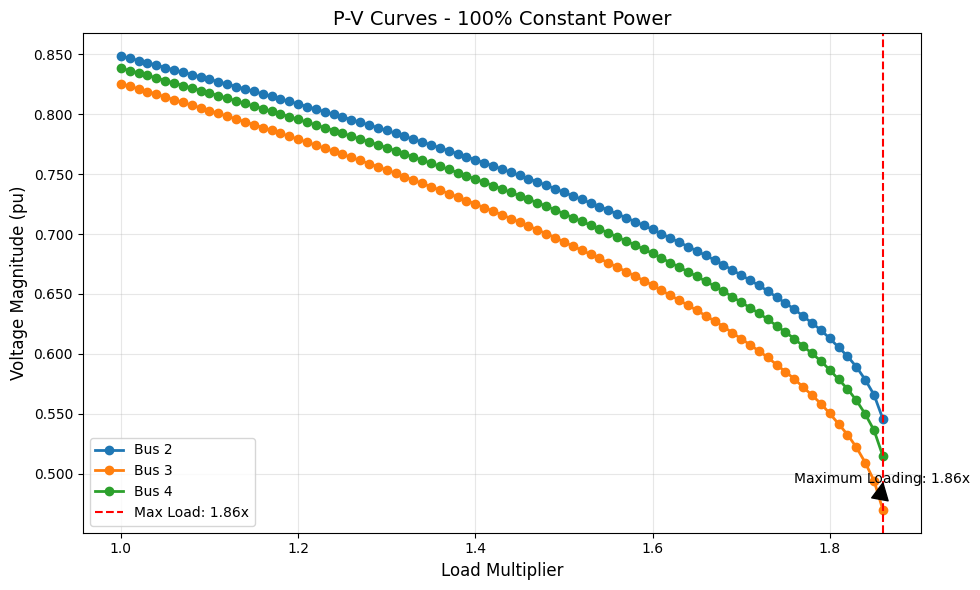


=== Running PV curve analysis for 100% Constant Current ===
Completed load multiplier: 1.20, voltages: V2=0.8482, V3=0.8255, V4=0.8380
Completed load multiplier: 1.40, voltages: V2=0.8226, V3=0.7960, V4=0.8107
Completed load multiplier: 1.60, voltages: V2=0.7969, V3=0.7665, V4=0.7833
Completed load multiplier: 1.80, voltages: V2=0.7713, V3=0.7370, V4=0.7559
Completed load multiplier: 2.00, voltages: V2=0.7456, V3=0.7075, V4=0.7285
Completed load multiplier: 2.20, voltages: V2=0.7198, V3=0.6779, V4=0.7011
Completed load multiplier: 2.40, voltages: V2=0.6942, V3=0.6484, V4=0.6737
Completed load multiplier: 2.60, voltages: V2=0.6684, V3=0.6187, V4=0.6462
Completed load multiplier: 2.80, voltages: V2=0.6427, V3=0.5892, V4=0.6187
Completed load multiplier: 3.00, voltages: V2=0.6169, V3=0.5596, V4=0.5913
Completed load multiplier: 3.20, voltages: V2=0.5912, V3=0.5299, V4=0.5638
Completed load multiplier: 3.40, voltages: V2=0.5656, V3=0.5005, V4=0.5364
Completed load multiplier: 3.60, voltag

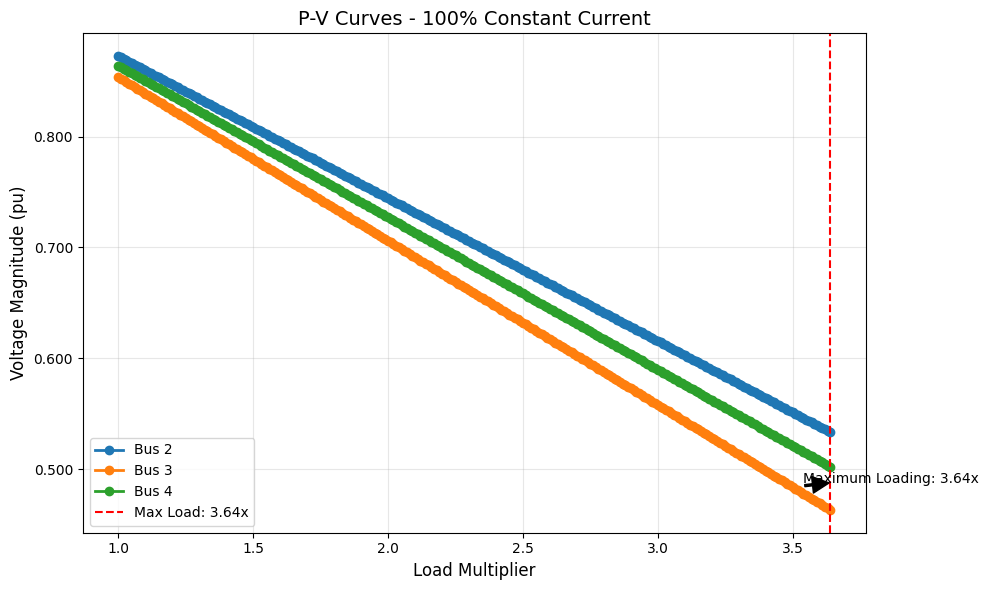


=== Running PV curve analysis for 100% Constant Impedance ===
Completed load multiplier: 1.20, voltages: V2=0.8691, V3=0.8499, V4=0.8604
Completed load multiplier: 1.40, voltages: V2=0.8504, V3=0.8284, V4=0.8404
Completed load multiplier: 1.60, voltages: V2=0.8325, V3=0.8079, V4=0.8213
Completed load multiplier: 1.80, voltages: V2=0.8154, V3=0.7884, V4=0.8030
Completed load multiplier: 2.00, voltages: V2=0.7991, V3=0.7698, V4=0.7857
Completed load multiplier: 2.20, voltages: V2=0.7835, V3=0.7520, V4=0.7690
Completed load multiplier: 2.40, voltages: V2=0.7683, V3=0.7347, V4=0.7529
Completed load multiplier: 2.60, voltages: V2=0.7538, V3=0.7182, V4=0.7374
Completed load multiplier: 2.80, voltages: V2=0.7400, V3=0.7024, V4=0.7227
Completed load multiplier: 3.00, voltages: V2=0.7266, V3=0.6872, V4=0.7085
Completed load multiplier: 3.20, voltages: V2=0.7137, V3=0.6726, V4=0.6947
Completed load multiplier: 3.40, voltages: V2=0.7013, V3=0.6585, V4=0.6815
Completed load multiplier: 3.60, volt

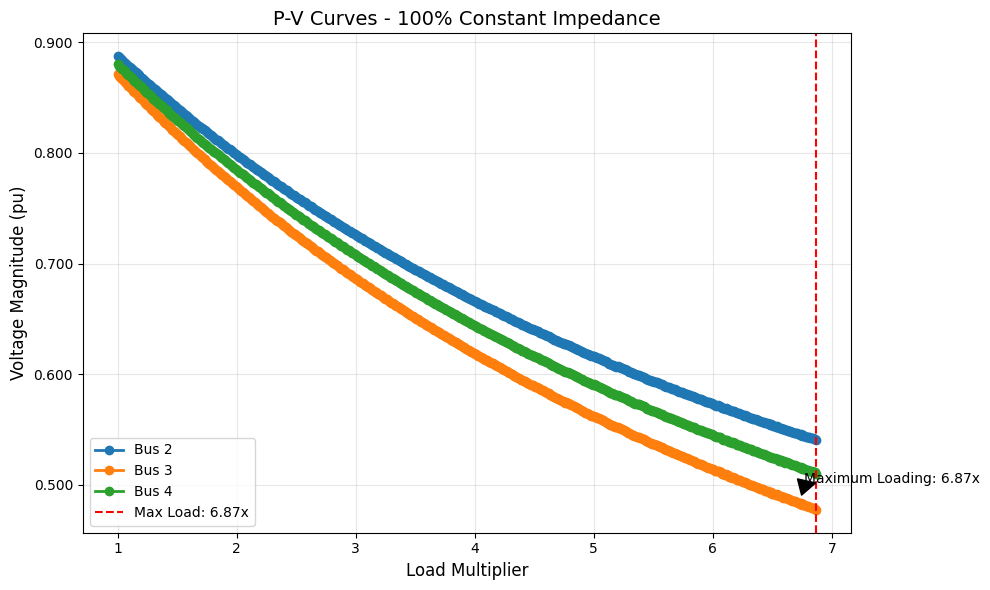


=== Running PV curve analysis for Mixed Model (ZIP) ===
Completed load multiplier: 1.20, voltages: V2=0.8438, V3=0.8203, V4=0.8333
Completed load multiplier: 1.40, voltages: V2=0.8159, V3=0.7881, V4=0.8035
Completed load multiplier: 1.60, voltages: V2=0.7872, V3=0.7551, V4=0.7729
Completed load multiplier: 1.80, voltages: V2=0.7576, V3=0.7208, V4=0.7413
Completed load multiplier: 2.00, voltages: V2=0.7266, V3=0.6851, V4=0.7082
Completed load multiplier: 2.20, voltages: V2=0.6939, V3=0.6472, V4=0.6733
Completed load multiplier: 2.40, voltages: V2=0.6589, V3=0.6066, V4=0.6359
Completed load multiplier: 2.60, voltages: V2=0.6203, V3=0.5616, V4=0.5947
Completed load multiplier: 2.80, voltages: V2=0.5759, V3=0.5096, V4=0.5472
Load multiplier 2.9500 failed to converge


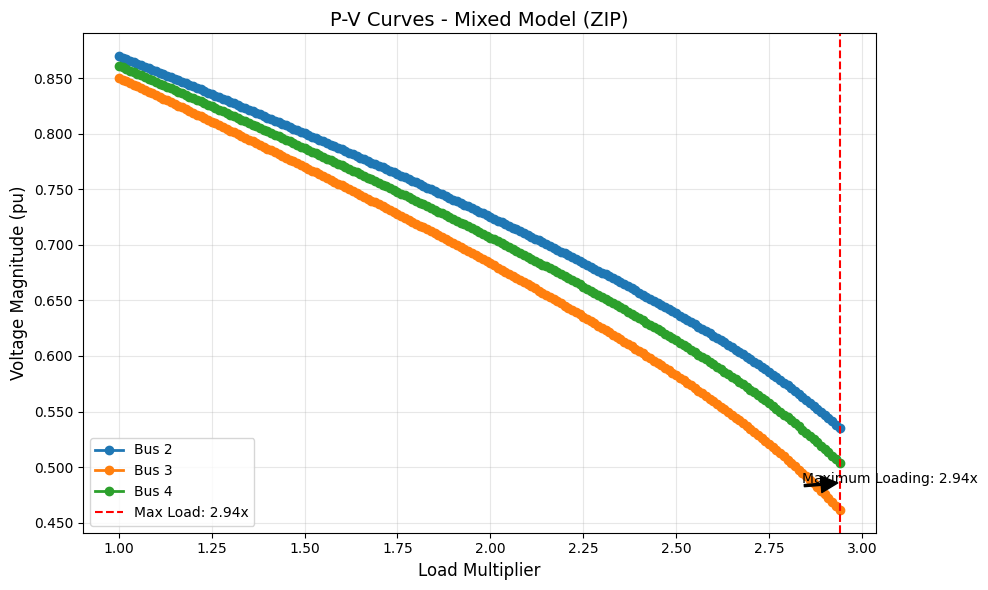

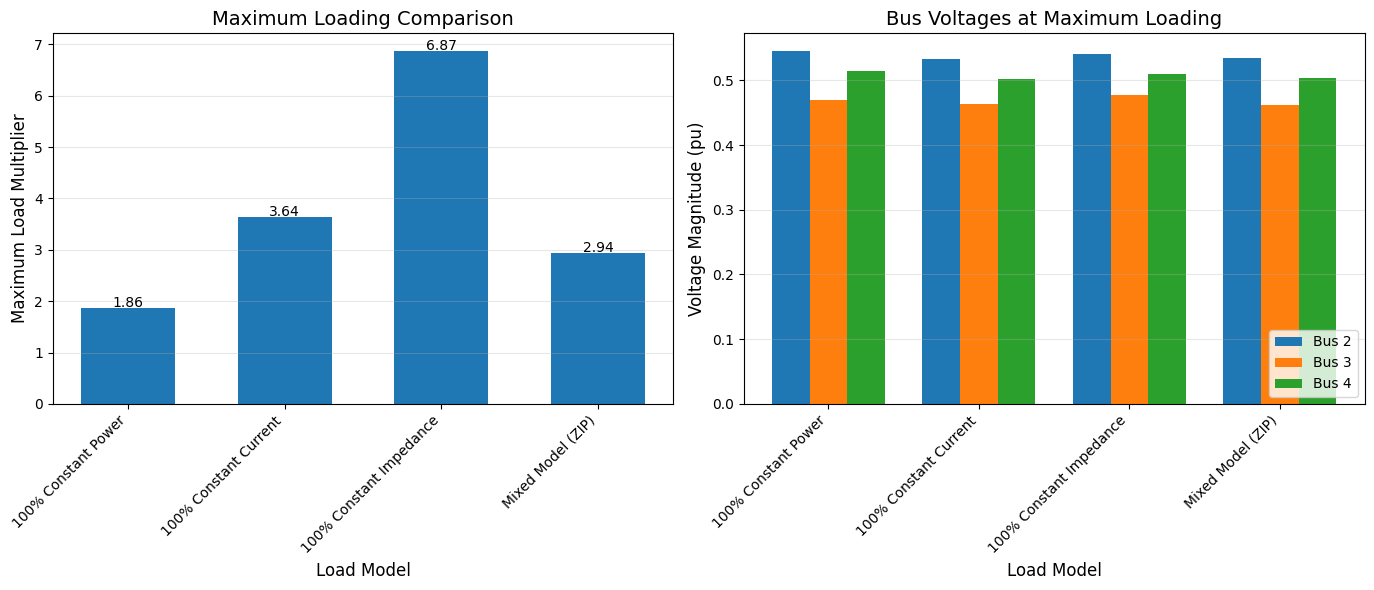


=== Maximum Loading Summary ===
Load Model                Max Load Factor
----------------------------------------
100% Constant Power       1.860          
100% Constant Current     3.640          
100% Constant Impedance   6.870          
Mixed Model (ZIP)         2.940          


In [2]:


results = run_pv_curve_analysis()

# Print maximum loading for each scenario
print("\n=== Maximum Loading Summary ===")
print("{:<25} {:<15}".format("Load Model", "Max Load Factor"))
print("-" * 40)

for name, res in results.items():
    last_idx = res['converged'].index(False) - 1 if False in res['converged'] else -1
    max_load = res['load_multipliers'][last_idx]
    print(f"{name:<25} {max_load:<15.3f}")